In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from ellipse_utils import (
    sample_2d_circle,
    ellipsify,
    get_ellipse_patch,
)

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 1
torch.manual_seed(seed)
num_samples = 8192
num_weights = 1024
nadir = torch.zeros(1, 2, **tkwargs)
base_samples = sample_2d_circle(n=num_samples, **tkwargs)
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Get the ellipses and samples.
radii = torch.tensor(
    [
        [0.2, 0.17],
        [0.12, 0.18],
        [0.15, 0.25],
        [0.2, 0.14],
        [0.14, 0.25],
        [0.14, 0.12],
        [0.20, 0.15],
    ],
    **tkwargs
)

angles = torch.tensor(
    [
        -0.2 * torch.pi,
        0.05 * torch.pi,
        -0.2 * torch.pi,
        0.05 * torch.pi,
        0.1 * torch.pi,
        0.15 * torch.pi,
        0.15 * torch.pi,
    ],
    **tkwargs
)
translates = torch.tensor(
    [
        [0.3, 0.8],
        [0.3, 0.50],
        [0.55, 0.57],
        [0.25, 0.30],
        [0.5, 0.30],
        [0.7, 0.40],
        [0.85, 0.15],
    ],
    **tkwargs
)

num_surface_samples = 512
t = torch.linspace(0, 1, num_surface_samples, **tkwargs)
surface_samples = torch.column_stack(
    [torch.cos(2 * torch.pi * t), torch.sin(2 * torch.pi * t)]
)
p_samples = []
for i in range(len(radii)):
    p_samples.append(
        ellipsify(
            surface_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

samples = []
for i in range(len(radii)):
    sample = ellipsify(
        base_samples, radius=radii[i], angle=angles[i], translate=translates[i]
    )
    aug_sample = torch.row_stack([sample, p_samples[i]])
    samples.append(aug_sample)

lengths = torch.stack([s_fn(s) for s in samples], dim=-1)

In [3]:
# Pareto front statistics.
q = 0.25
max_lengths = lengths.max(dim=-1).values
quantile_length = max_lengths.quantile(q=q, dim=0)
quantile_front = nadir + quantile_length.unsqueeze(-1) * weights

cvar_length = torch.zeros_like(quantile_length)
for i in range(num_weights):
    max_lengths_i = max_lengths[:, i]
    cvar_length[i] = max_lengths_i[max_lengths_i <= quantile_length[i]].mean()

cvar_front = nadir + cvar_length.unsqueeze(-1) * weights

mean_front = nadir + max_lengths.mean(dim=0).unsqueeze(-1) * weights
min_front = nadir + max_lengths.min(dim=0).values.unsqueeze(-1) * weights
max_front = nadir + max_lengths.max(dim=0).values.unsqueeze(-1) * weights

In [4]:
# RTS statistics.
rts_mean = torch.row_stack([s.mean(dim=0) for s in samples])
rts_mean_lengths = s_fn(rts_mean).max(dim=0).values
rts_mean_front = nadir + rts_mean_lengths.unsqueeze(-1) * weights

rts_min = torch.row_stack([s.min(dim=0).values for s in samples])
rts_min_lengths = s_fn(rts_min).max(dim=0).values
rts_min_front = nadir + rts_min_lengths.unsqueeze(-1) * weights

rts_max = torch.row_stack([s.max(dim=0).values for s in samples])
rts_max_lengths = s_fn(rts_max).max(dim=0).values
rts_max_front = nadir + rts_max_lengths.unsqueeze(-1) * weights

# Calculate the DR worst case.
all_samples = torch.row_stack([s[is_non_dominated(-s)] for s in p_samples])

rts_dr_lengths = s_fn(all_samples).max(dim=0).values
rts_dr_front = nadir + rts_dr_lengths.unsqueeze(-1) * weights

In [5]:
# STR statistics.
str_mean_lengths = lengths.mean(dim=0).max(dim=-1).values
str_mean_front = nadir + str_mean_lengths.unsqueeze(-1) * weights

str_min_lengths = lengths.min(dim=0).values.max(dim=-1).values
str_min_front = nadir + str_min_lengths.unsqueeze(-1) * weights

str_max_lengths = lengths.max(dim=0).values.max(dim=-1).values
str_max_front = nadir + str_max_lengths.unsqueeze(-1) * weights

str_quantile = lengths.quantile(q=q, dim=0)
str_quantile_lengths = str_quantile.max(dim=-1).values
str_quantile_front = nadir + str_quantile_lengths.unsqueeze(-1) * weights

str_cvar = torch.zeros_like(str_quantile)
for i in range(num_weights):
    for j in range(len(radii)):
        lengths_ij = lengths[:, i, j]
        str_cvar[i, j] = lengths_ij[lengths_ij < str_quantile[i, j]].mean()

str_cvar_lengths = str_cvar.max(dim=-1).values
str_cvar_front = nadir + str_cvar_lengths.unsqueeze(-1) * weights

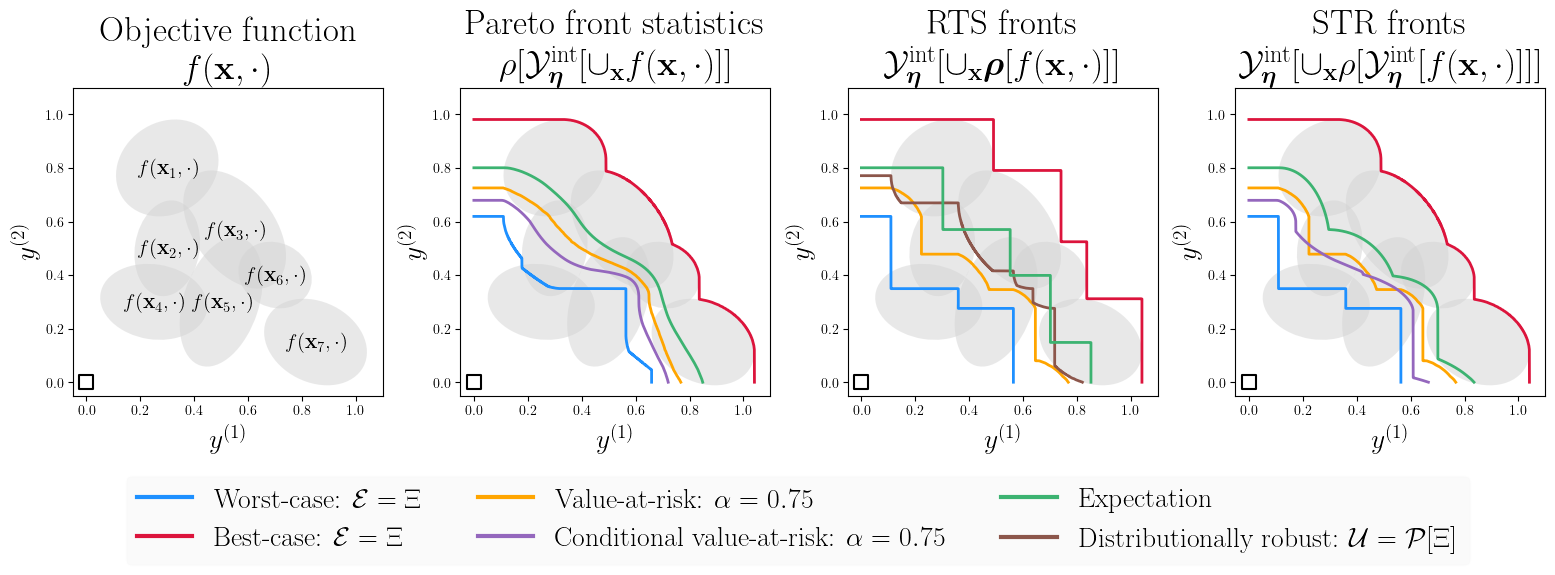

In [6]:
num_rows = 1
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(19, 4))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.15
)

for j in range(num_rows * num_cols):
    ax = plt.subplot(num_rows, num_cols, j + 1)

    plt.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

    for i in range(len(radii)):
        ellipse, transform = get_ellipse_patch(
            radius=radii[i],
            angle=angles[i],
            translate=translates[i],
            alpha=0.5,
            facecolor="lightgray",
        )
        ellipse.set_transform(transform + ax.transData)
        ax.add_patch(ellipse)

    plt.xlim(-0.05, 1.1)
    plt.ylim(-0.05, 1.1)
    plt.xlabel(r"$y^{(1)}$", fontsize=20)
    plt.ylabel(r"$y^{(2)}$", fontsize=20)

ax = plt.subplot(num_rows, num_cols, 1)
delta = torch.tensor(
    [
        [-0.11, -0.02],
        [-0.11, -0.02],
        [-0.11, -0.02],
        [-0.11, -0.02],
        [-0.11, -0.02],
        [-0.11, -0.02],
        [-0.11, -0.02],
    ],
    **tkwargs,
)
for i, t in enumerate(translates):
    d = delta[i]
    ax.annotate(
        rf"$f(\mathbf{{x}}_{i+1}, \cdot)$",
        (t[0] + d[0], t[1] + d[1]),
        fontsize=15,
        color="k",
        zorder=5,
    )
plt.title("Objective function \n" + r"$f(\mathbf{x}, \cdot)$", fontsize=25)
############################################################################################
# Pareto front statistics.
plt.subplot(num_rows, num_cols, 2)
plt.plot(
    mean_front[:, 0], mean_front[:, 1], color="mediumseagreen", zorder=4, linewidth=2
)
plt.plot(min_front[:, 0], min_front[:, 1], color="dodgerblue", linewidth=2)
plt.plot(max_front[:, 0], max_front[:, 1], color="crimson", linewidth=2)
plt.plot(quantile_front[:, 0], quantile_front[:, 1], color="orange", linewidth=2)
plt.plot(cvar_front[:, 0], cvar_front[:, 1], color="tab:purple", linewidth=2)
plt.title(
    "Pareto front statistics \n"
    + r"$\rho[\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[\cup_{\mathbf{x}}f(\mathbf{x}, \cdot)]]$",
    fontsize=25,
)
############################################################################################
# RTS.
plt.subplot(num_rows, num_cols, 3)
plt.plot(
    rts_mean_front[:, 0],
    rts_mean_front[:, 1],
    color="mediumseagreen",
    zorder=4,
    linewidth=2,
)
plt.plot(
    rts_min_front[:, 0], rts_min_front[:, 1], color="dodgerblue", zorder=4, linewidth=2
)
plt.plot(
    rts_max_front[:, 0], rts_max_front[:, 1], color="crimson", zorder=4, linewidth=2
)
plt.plot(
    str_quantile_front[:, 0], str_quantile_front[:, 1], color="orange", linewidth=2
)
plt.plot(rts_dr_front[:, 0], rts_dr_front[:, 1], color="tab:brown", linewidth=2)

plt.title(
    "RTS fronts \n"
    + r"$\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[\cup_{\mathbf{x}}\boldsymbol{\rho}[f(\mathbf{x}, \cdot)]]$",
    fontsize=25,
)
############################################################################################
# STR.
plt.subplot(num_rows, num_cols, 4)
plt.plot(
    str_mean_front[:, 0],
    str_mean_front[:, 1],
    color="mediumseagreen",
    zorder=4,
    linewidth=2,
)
plt.plot(str_min_front[:, 0], str_min_front[:, 1], color="dodgerblue", linewidth=2)
plt.plot(str_max_front[:, 0], str_max_front[:, 1], color="crimson", linewidth=2)
plt.plot(
    str_quantile_front[:, 0], str_quantile_front[:, 1], color="orange", linewidth=2
)
plt.plot(str_cvar_front[:, 0], cvar_front[:, 1], color="tab:purple", linewidth=2)

plt.title(
    "STR fronts \n"
    + r"$\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[\cup_{\mathbf{x}}\rho[\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[f(\mathbf{x}, \cdot)]]]$",
    fontsize=25,
)
############################################################################################
# Legend.

blue_line = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    linestyle="-",
    linewidth=3,
    label=r"Worst-case: $\mathcal{E} = \Xi$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    label=r"Best-case: $\mathcal{E} = \Xi$",
)

green_line = mlines.Line2D(
    [],
    [],
    color="mediumseagreen",
    linestyle="-",
    linewidth=3,
    label=r"Expectation",
)

orange_line = mlines.Line2D(
    [],
    [],
    color="orange",
    linestyle="-",
    linewidth=3,
    label=rf"Value-at-risk: $\alpha={1-q}$",
)

purple_line = mlines.Line2D(
    [],
    [],
    color="tab:purple",
    linestyle="-",
    linewidth=3,
    label=rf"Conditional value-at-risk: $\alpha={1-q}$",
)

brown_line = mlines.Line2D(
    [],
    [],
    color="tab:brown",
    linestyle="-",
    linewidth=3,
    label=r"Distributionally robust: $\mathcal{U}=\mathcal{P}[\Xi]$",
)

axes[0].legend(
    handles=[
        blue_line,
        red_line,
        orange_line,
        purple_line,
        green_line,
        brown_line,
    ],
    ncol=3,
    fontsize=20,
    loc=(0.17, -0.55),
    facecolor="k",
    framealpha=0.02,
)

plt.show()